<a href="https://colab.research.google.com/github/LeeYuuuan/EIT-based-on-DDPM/blob/main/DDPMforEIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import torch

Mounted at /content/drive


### 1. EIT data

In [3]:
## TODO


### 2. StanfordCars Data

In [ ]:
%pip install opendatasets

#### username & key

username

jonfflynn

key

173571be6c539c06b0cf8e06153d5573


#### 2.1 download

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jonfflynn
Your Kaggle Key: ··········


100%|██████████| 1.82G/1.82G [01:03<00:00, 30.9MB/s]


#### 2.2

Move to Google drive

Remove recursive directory structure

In [6]:
%ls

drive/  sample_data/  stanford-cars-dataset/


In [11]:
import shutil
# import os
# os.rename("content/stanford-cars-dataset/cars_test/cars_test", "content/drive/MyDrive/Colab Notebooks/DDPM_EIT/stanford_cars/cars_test")
# os.rename("content/stanford-cars-dataset/cars_test/cars_test", "content/drive/MyDrive/Colab Notebooks/DDPM_EIT/stanford_cars/cars_train")
shutil.move("/content/stanford-cars-dataset/cars_test/cars_test", "/content/drive/MyDrive/Colab Notebooks/DDPM_EIT/stanford_cars/cars_test")
shutil.move("/content/stanford-cars-dataset/cars_train/cars_train", "/content/drive/MyDrive/Colab Notebooks/DDPM_EIT/stanford_cars/cars_train")

'/content/drive/MyDrive/Colab Notebooks/DDPM_EIT/stanford_cars/cars_train'

In [13]:
%rm -r stanford-cars-dataset

##### no use

In [58]:
%rm -rf stanford_cars/cars_test_1
%rm -rf stanford_cars/cars_train_1


In [49]:
%rm -rf stanford-car-dataset-by-classes-folder/
%rm -rf stanford_cars/
os.rename("stanford-cars-dataset", "stanford_cars")

#### 2.3 Load data

In [ ]:
# for test
[os.path.join("/content/stanford_cars/cars_train", file) for file in os.listdir("/content/stanford_cars/cars_train")]


##### 2.3.1 Custom <StanfordCars> Dataset

In [41]:
import torch
class StanfordCars(torch.utils.data.Dataset):
    def __init__(self, train_or_test = "train", transform = None):
        root_path = "/content/drive/MyDrive/Colab Notebooks/DDPM_EIT/stanford_cars/cars_" + train_or_test
        self.images = [os.path.join(root_path, file) for file in os.listdir(root_path)]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_file = self.images[index]
        image = Image.open(image_file).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


##### 2.3.2 Investigating the dataset

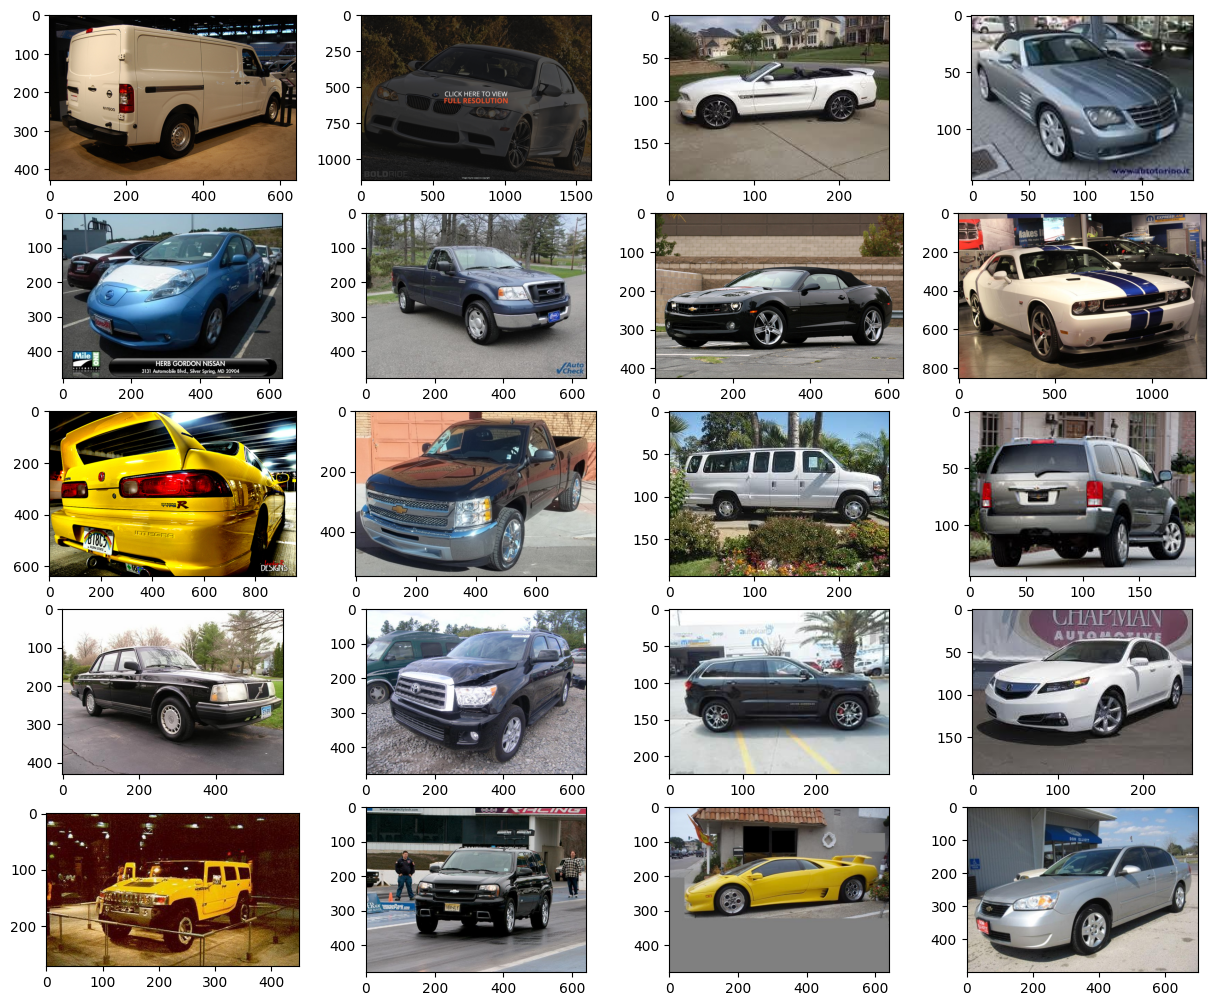

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
try:
    from PIL import Image
except ImportError:
    import Image
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img)

data = StanfordCars()

# data = torchvision.datasets.StanfordCars(root=".", download=True)
show_images(data)

##### 2.3.3 Transform and Load

In [53]:
def load_transformed_dataset():

    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)
    train = StanfordCars(train_or_test="train", transform=data_transform)
    test = StanfordCars(train_or_test="test", transform=data_transform)
    return torch.utils.data.ConcatDataset([train, test])


In [54]:
def show_tensor_image(image):

    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

In [55]:
from torch.utils.data import DataLoader
import numpy as np

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [29]:
# for test
from torchvision import transforms
IMG_SIZE = 32
BATCH_SIZE = 128
data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
data_transform = transforms.Compose(data_transforms)
data = StanfordCars(transform=data_transform)
data.__getitem__(0).shape

torch.Size([1, 3, 32, 32])

## Step 1: The Forward Process

### Get beta schedule

#### Method 1. Get a pre-defined beta schedule

https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/gaussian_diffusion.py

In [ ]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")



#### Method 2. Linear beta schedule

https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=qWw50ui9IZ5q

In [49]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

### Forward

In [50]:
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

<ipython-input-56-f4853fe96c6f>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


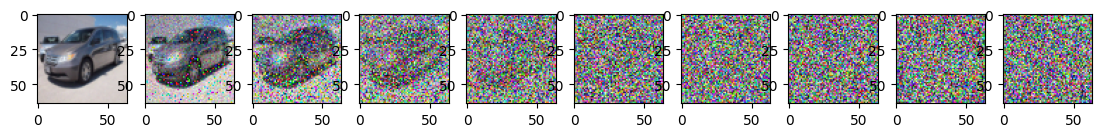

In [56]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [58]:
image.shape

torch.Size([3, 64, 64])

## Step 2: The backward process = U-Net